In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


# Setting

In [39]:
data_root_dir = "/nfs_share/students/jinhyun/TCGA/BRCA"
result_file_path = "results/prognosis_predictions_1.xlsx"
result_file_path = "results/prognosis_predictions_2.xlsx"

# Evaluate

In [40]:
def prepare_df(result_file_path):
    df = pd.read_excel(result_file_path)
    df['Predicted Prognosis'] = df['Predicted Prognosis'].astype(str).str.split('\n').str[0]
    return df


In [42]:
# Extract unique labels and sort them based on the number preceding '-'
def extract_numeric_part(label):
    return int(label.split('-')[0]) if label.split('-')[0].isdigit() else float('inf')

def evaluate_model(df):
    labels = sorted(df["Actual Prognosis"].unique(), key=extract_numeric_part)
    y_true = df["Actual Prognosis"]
    y_pred = df["Predicted Prognosis"]

    # Compute accuracy and F1-score
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted to consider class imbalance
    
    # Print accuracy and F1-score
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=45)
    plt.show()


In [ ]:
evaluate_model(prepare_df(result_file_path)) #2

Accuracy: 0.2516
F1 Score: 0.2255


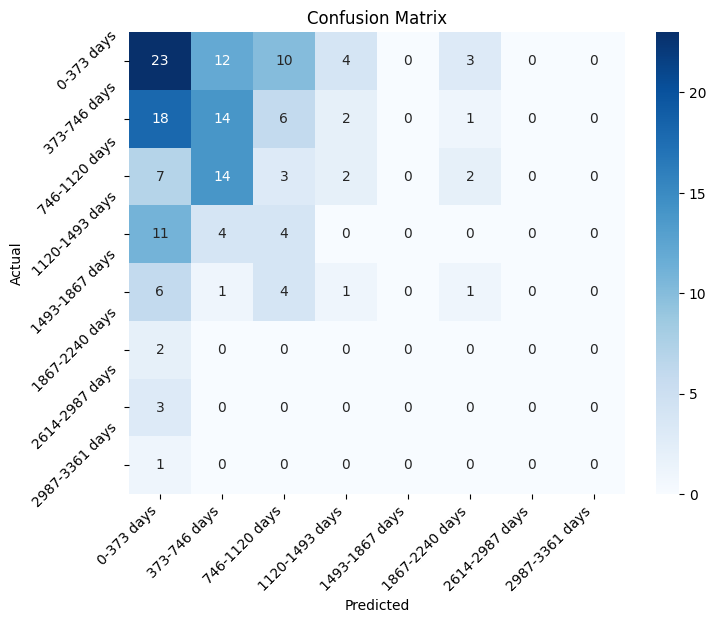

In [24]:
evaluate_model(prepare_df(result_file_path)) #1